In [1]:
import pandas as pd
from scipy.stats import kendalltau
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from math import floor


In [2]:
datasets = {
    'recsys2015': [
        # "EASE",
        "GRU4RecNegSampling",
        "ItemKNN",
        "Popularity",
        "SequentialRules",
        "TARSItemKNNDing",
        "TARSItemKNNLiu",
    ],
    'cosmeticsshop': [
        "EASE",
        "GRU4RecNegSampling",
        "ItemKNN",
        "Popularity",
        "SequentialRules",
        "TARSItemKNNDing",
        "TARSItemKNNLiu",
    ],
    'adressa': [
        "EASE",
        "GRU4RecNegSampling",
        "ItemKNN",
        "Popularity",
        "SequentialRules",
        "TARSItemKNNDing",
        "TARSItemKNNLiu",
    ]
}

def load_optimisation_data(dataset):
    algorithms = datasets[dataset]
    optimisation_data = []
    for algo in algorithms:
        results = pd.read_csv(f'results_hyperopt/{dataset}/optimisation_results_{algo}.csv')
        results['algorithm'] = algo
        
        # if algo == 'GRU4RecNegSampling' and dataset == 'adressa':
        #     sample = results.sample(15)
        #     best = results.sort_values('ndcg').tail(5)
        #     results = pd.concat([sample, best])
            
        optimisation_data.append(results)

    optimisation_df = pd.concat(optimisation_data, ignore_index=True)
    optimisation_df.algorithm = optimisation_df.algorithm.map(
        lambda x: 'GRU4Rec' if x in ('GRU4RecCrossEntropy', 'GRU4RecNegSampling') else x
    )
    return optimisation_df#[optimisation_df.similarity != 1]

In [3]:
pd.set_option('display.max_colwidth', None)


In [4]:
def table_styler(styler, precision=2):
    styler.applymap_index(
        lambda v: "font-weight: bold;", axis="columns"
    )
    # fp precision 
    styler.format(precision=precision)
    return styler

def column_rename(column_name):
    """For ease of reading we change some columns before rendering them in latex"""
    name_mapping = {
        'inf': '$\infty$',
        'window_hours': '$\delta$ (h)',
        'recsys2015': 'Yoochoose',
        'adressa': 'Adressa',
        'cosmeticsshop': 'CosmeticsShop',
    }
    return name_mapping.get(column_name, column_name)

def algorithm_rename(algo_name):
    name_mapping = {
        'TARSItemKNNDing': 'IKNN Ding',
        'TARSItemKNNLiu': 'IKNN Liu',
        'SequentialRules': 'SR',
        'EASE': 'EASE\\textsuperscript{r}',
        'GRU4RecNegSampling': 'GRU4Rec',
    }
    return name_mapping.get(algo_name, algo_name)


def table_styler_latex(styler, precision=2):
    styler = table_styler(styler, precision)
    # Replace inf with $\infty$ for proper rendering
    styler.format_index(lambda v: column_rename(v), axis='columns')
    # overwrite formatter to replace algorithm names.
    styler.format_index(algorithm_rename, axis='index')

    return styler

def make_results_table(df, metric, to_percentage=False):
    render_df = df.pivot('algorithm', columns=['dataset', 'delta'], values=metric)[datasets.keys()]
    if to_percentage:
        render_df = render_df*100 # get percentages
    return render_df
    
def render_metric_table(df, metric, latex=False, percentage=False, precision=2):
    res_table = make_results_table(df, metric, percentage)
    if latex:
        t = table_styler_latex(res_table.style, precision=precision).to_latex(multicol_align='c', hrules=True, convert_css=True)
        return t
    else:
        return table_styler(res_table.style, precision=precision)

def render_corr_row(df):
    correlations = [df[df.dataset == d].correlation.values[0] for d in df.dataset.unique()]

    return f"""\\midrule
correlation & {' & '.join(['multicolumn{2}{c}{'f'{corr:.2f}''}' for corr in correlations])} \\\\
\\bottomrule""".replace("multicolumn", "\multicolumn")

def render_ndcg_table_latex(df, corr_df):
    t = render_metric_table(df, metric='ndcgk_10', latex=True, percentage=True)
    return t.replace("\\bottomrule", render_corr_row(corr_df))


In [5]:
def make_delta_results_table(df):
    render_df = df.pivot('algorithm', columns=['dataset'], values='window_hours')[list(datasets.keys())]
    return render_df

def render_delta_table(df, latex=False):
    res_table = make_delta_results_table(df)
    if latex:
        t = table_styler_latex(res_table.style, precision=0).to_latex(multicol_align='c', hrules=True, convert_css=True)
        return t
    else:
        return table_styler(res_table.style, precision=0)


In [6]:
full_data = []
corr_data = []
for dataset in datasets:
    for algo in datasets[dataset]:
        temp_inf = pd.read_csv(f'results_hyperopt/{dataset}/full_window_result_{algo}.csv').rename(
            columns={'Unnamed: 0': 'identifier'})
        temp_inf['algorithm'] = temp_inf.identifier.map(lambda x: x.split('(')[0])
        temp_inf['dataset'] = dataset
        temp_inf['delta'] = 'inf'
        full_data.append(temp_inf)
        temp_optim = pd.read_csv(f'results_hyperopt/{dataset}/final_result_{algo}.csv').rename(
            columns={'Unnamed: 0': 'identifier'})
        temp_optim['algorithm'] = temp_optim.identifier.map(lambda x: x.split('(')[0])
        temp_optim['dataset'] = dataset
        temp_optim['delta'] = 'optim'
        full_data.append(temp_optim)

full_df = pd.concat(full_data, ignore_index=True)

for dataset in datasets:
    corr = kendalltau(
        full_df[(full_df.dataset == dataset) & (full_df.delta=='inf')].ndcgk_10.fillna(0), 
        full_df[(full_df.dataset == dataset) & (full_df.delta=='optim')].ndcgk_10.fillna(0)
    )
    corr_data.append({'dataset': dataset, 'correlation': corr.correlation,})

corr_df = pd.DataFrame.from_records(corr_data)



In [7]:
parts = []
for ds in datasets:
    optimisation_df = load_optimisation_data(ds)
    optimisation_df['dataset'] = ds
    parts.append(optimisation_df)

full_optimisation_df = pd.concat(parts, ignore_index=True)
optimal_deltas = full_optimisation_df.sort_values('ndcg', ascending=False).groupby(['dataset', 'algorithm']).first()[['window_hours', 'ndcg']].reset_index()

## Evaluation Metrics

To generate a table for a metric, change the metric name in the `render_metric_table` call.
A list of supported metrics can be found below.

In [8]:
supported_metrics = set(full_df.columns) - {'identifier', 'algorithm', 'dataset', 'delta'}
supported_metrics

{'calibratedrecallk_10',
 'calibratedrecallk_20',
 'calibratedrecallk_50',
 'coveragek_10',
 'coveragek_20',
 'coveragek_50',
 'ndcgk_10',
 'ndcgk_20',
 'ndcgk_50',
 'precisionk_10',
 'precisionk_20',
 'precisionk_50',
 'reciprocalrankk_10',
 'reciprocalrankk_20',
 'reciprocalrankk_50'}

In [9]:
render_metric_table(full_df, 'ndcgk_10', percentage=True)

## Optimal Deltas
Render a table with the optimal delta values for algorithm and dataset combinations.

In [10]:
render_delta_table(optimal_deltas)

dataset,recsys2015,cosmeticsshop,adressa
algorithm,,,
EASE,nan,389,3
GRU4Rec,733,1562,121
ItemKNN,228,2368,5
Popularity,26,287,1
SequentialRules,185,3573,18
TARSItemKNNDing,214,2278,5
TARSItemKNNLiu,280,1939,117


## Runtimes
Creates a table with the runtimes of dataset-algorithm combinations.

In [11]:
max_runtimes = full_optimisation_df.sort_values('ndcg', ascending=False).groupby(['dataset', 'algorithm'])[['run_time']].max().reset_index()
max_runtimes['delta'] = 'inf'

optim_runtimes = full_optimisation_df.sort_values('ndcg', ascending=False).groupby(['dataset', 'algorithm']).first()[['run_time']].reset_index()
optim_runtimes['delta'] = 'optim'

# Sort to make rendering work
run_times = pd.concat([max_runtimes, optim_runtimes], ignore_index=True).sort_values(['dataset', 'delta'])


## Plotting

In addition to the tables we also inspect the trends through all points.

In [12]:
LABEL_FONTSIZE = 13
TITLE_FONTSIZE = 16
TICK_FONTSIZE = 13
POINTSIZE = 150

def plot(df, ax, ax_title, y_col, y_label, x_col, x_label, x_log_scale=False, y_log_scale=False):
    seaborn.scatterplot(
        data=df, 
        x=x_col,
        y=y_col,
        hue='algorithm',
        style='algorithm',
        alpha=0.7,
        s=POINTSIZE,
        ax=ax,
    )
    if x_log_scale:
        ax.set_xscale('log')
    if y_log_scale:
        ax.set_yscale('log')
    ax.set_ylabel(y_label, fontsize=LABEL_FONTSIZE)
    ax.set_xlabel(x_label, fontsize=LABEL_FONTSIZE)
    ax.set_title(ax_title, fontsize=TITLE_FONTSIZE)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.tick_params(labelsize=TICK_FONTSIZE)
    return handles, labels


def plot_optimisation_ndcg(df, ax, ax_title, x_log_scale=True):
    """Plots the optimisation results, and returns the handles and labels."""
    return plot(
        df, 
        ax, 
        ax_title,
        y_col='ndcg',
        y_label='NDCG',
        x_col='window_hours',
        x_label='delta (h)',
        x_log_scale=x_log_scale
    )

def plot_optimisation_runtime(df, ax, ax_title, x_log_scale=True):
    """Plots the optimisation results, and returns the handles and labels."""
    return plot(
        df, 
        ax, 
        ax_title,
        y_col='run_time',
        y_label='run time (s)',
        x_col='window_hours',
        x_label='delta (h)',
        x_log_scale=x_log_scale,
        y_log_scale=True
    )


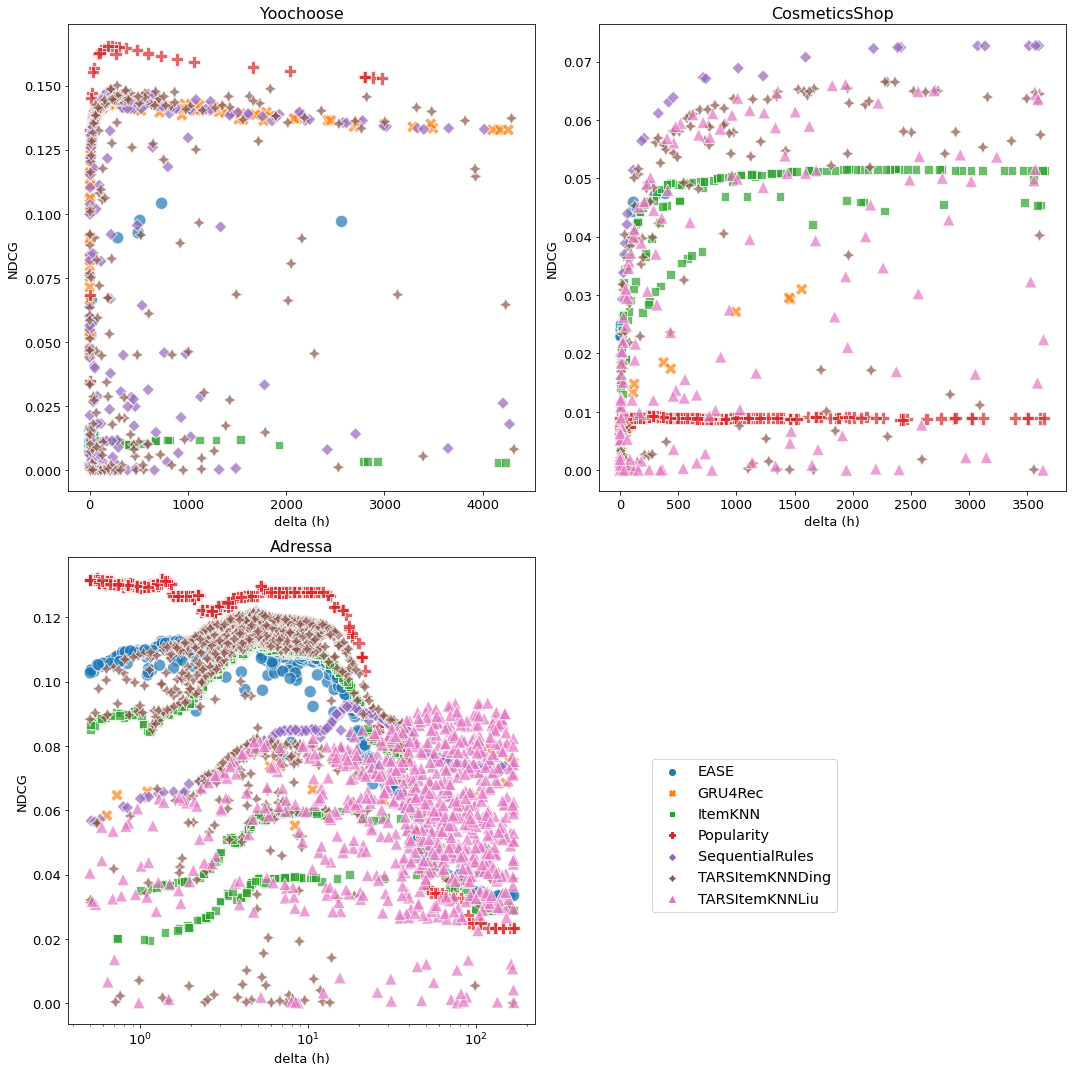

In [15]:
fig = plt.figure(figsize=(15,15))

gs = plt.GridSpec(4, 2, figure=fig)
ax_recs = fig.add_subplot(gs[0:2, 0])
ax_cosm = fig.add_subplot(gs[0:2, 1])
ax_addr = fig.add_subplot(gs[2:4, 0])


handles, labels = plot_optimisation_ndcg(load_optimisation_data('recsys2015'), ax_recs, 'Yoochoose', x_log_scale=False)
handles, labels = plot_optimisation_ndcg(load_optimisation_data('cosmeticsshop'), ax_cosm, 'CosmeticsShop', x_log_scale=False)

handles, labels = plot_optimisation_ndcg(load_optimisation_data('adressa'), ax_addr, 'Adressa')


fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.6, 0.3), fontsize='x-large')

plt.tight_layout()
# fig.savefig('plots/optimisation_ndcg_3_2.pdf')


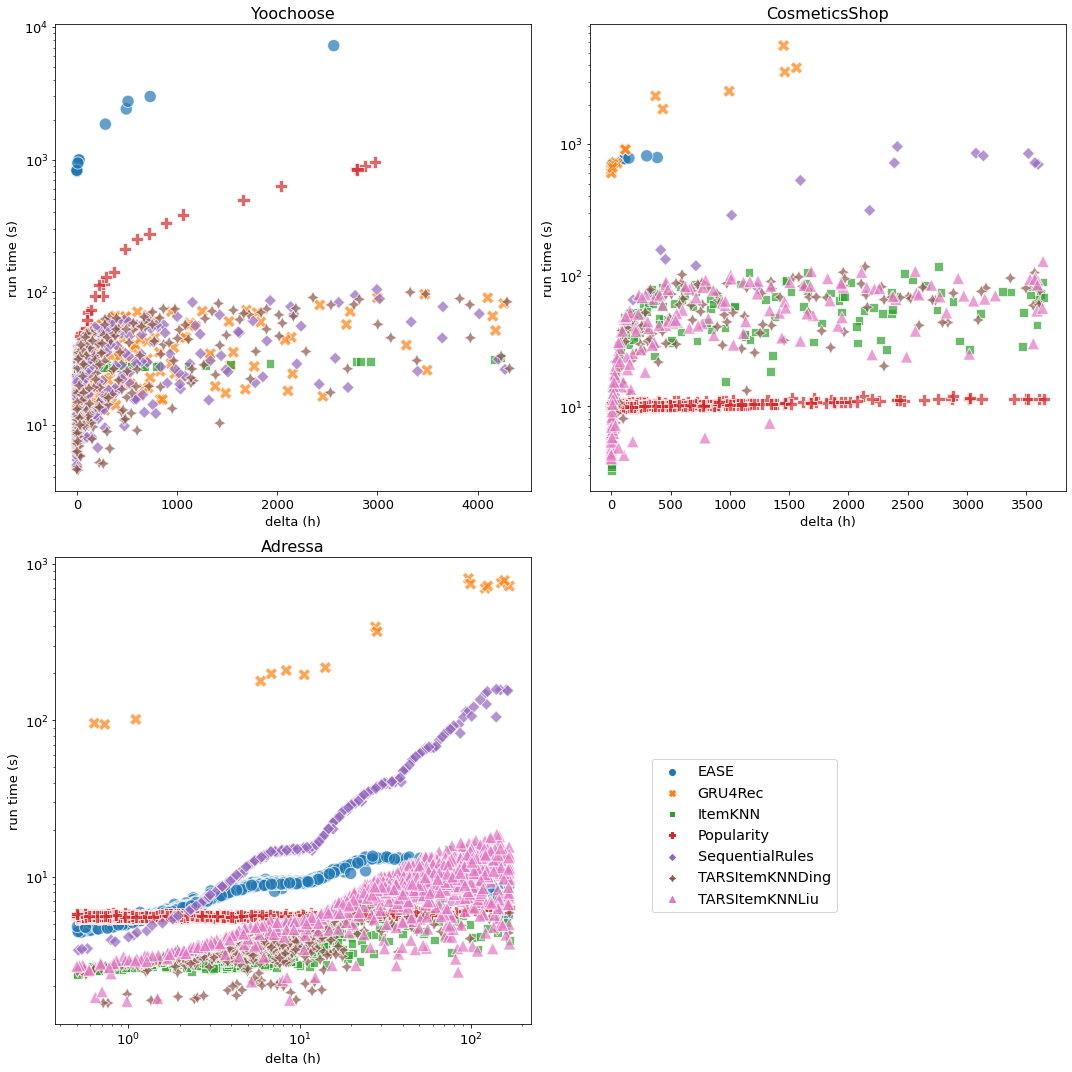

In [16]:
fig = plt.figure(figsize=(15,15))

gs = plt.GridSpec(4, 2, figure=fig)

ax_recs = fig.add_subplot(gs[0:2, 0])
ax_cosm = fig.add_subplot(gs[0:2, 1])
ax_addr = fig.add_subplot(gs[2:4, 0])


handles, labels = plot_optimisation_runtime(load_optimisation_data('recsys2015'), ax_recs, 'Yoochoose', x_log_scale=False)
handles, labels = plot_optimisation_runtime(load_optimisation_data('cosmeticsshop'), ax_cosm, 'CosmeticsShop', x_log_scale=False)

handles, labels = plot_optimisation_runtime(load_optimisation_data('adressa'), ax_addr, 'Adressa')


fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.6, 0.3), fontsize='x-large')

plt.tight_layout()
# fig.savefig('plots/optimisation_runtime_3_2.pdf')


## Tables for paper
We use pandas latex rendering functionality to easily generate our tables

In [19]:
print(render_delta_table(optimal_deltas, latex=True))

\begin{tabular}{lrrr}
\toprule
dataset & \bfseries Yoochoose & \bfseries CosmeticsShop & \bfseries Adressa \\
algorithm &  &  &  \\
\midrule
EASE\textsuperscript{r} & nan & 389 & 3 \\
GRU4Rec & 733 & 1562 & 121 \\
ItemKNN & 228 & 2368 & 5 \\
Popularity & 26 & 287 & 1 \\
SR & 185 & 3573 & 18 \\
IKNN Ding & 214 & 2278 & 5 \\
IKNN Liu & 280 & 1939 & 117 \\
\bottomrule
\end{tabular}



In [20]:
print(render_ndcg_table_latex(full_df, corr_df))

\begin{tabular}{lrrrrrr}
\toprule
dataset & \multicolumn{2}{c}{\bfseries Yoochoose} & \multicolumn{2}{c}{\bfseries CosmeticsShop} & \multicolumn{2}{c}{\bfseries Adressa} \\
delta & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim \\
algorithm &  &  &  &  &  &  \\
\midrule
EASE\textsuperscript{r} & nan & nan & 4.84 & 4.60 & 0.82 & 6.98 \\
GRU4Rec & 13.57 & 13.61 & 3.30 & 2.93 & 4.06 & 3.87 \\
ItemKNN & 16.50 & 17.84 & 4.89 & 4.90 & 0.44 & 5.40 \\
Popularity & 0.36 & 1.12 & 0.88 & 1.07 & 0.37 & 12.57 \\
SR & 19.04 & 20.69 & 7.23 & 7.23 & 3.59 & 4.53 \\
IKNN Ding & 17.10 & 18.52 & 6.44 & 6.43 & 0.60 & 6.44 \\
IKNN Liu & 18.84 & 18.68 & 6.41 & 6.40 & 3.92 & 3.91 \\
\midrule
correlation & \multicolumn{2}{c}{1.00} & \multicolumn{2}{c}{1.00} & \multicolumn{2}{c}{-0.71} \\
\bottomrule
\end{tabular}



In [21]:
print(render_metric_table(full_df, 'coveragek_10', percentage=True, latex=True))

\begin{tabular}{lrrrrrr}
\toprule
dataset & \multicolumn{2}{c}{\bfseries Yoochoose} & \multicolumn{2}{c}{\bfseries CosmeticsShop} & \multicolumn{2}{c}{\bfseries Adressa} \\
delta & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim \\
algorithm &  &  &  &  &  &  \\
\midrule
EASE\textsuperscript{r} & nan & nan & 60.86 & 56.81 & 23.19 & 13.91 \\
GRU4Rec & 71.52 & 52.75 & 70.02 & 66.84 & 34.52 & 32.69 \\
ItemKNN & 76.51 & 63.10 & 59.95 & 61.30 & 10.39 & 16.74 \\
Popularity & 0.07 & 0.13 & 0.20 & 0.15 & 1.94 & 0.90 \\
SR & 85.83 & 65.46 & 92.47 & 92.47 & 41.29 & 23.23 \\
IKNN Ding & 88.47 & 71.90 & 93.68 & 93.99 & 14.62 & 17.03 \\
IKNN Liu & 78.28 & 73.22 & 93.19 & 93.98 & 71.36 & 68.57 \\
\bottomrule
\end{tabular}



In [22]:
print(render_metric_table(run_times, 'run_time', latex=True, precision=0))

\begin{tabular}{lrrrrrr}
\toprule
dataset & \multicolumn{2}{c}{\bfseries Yoochoose} & \multicolumn{2}{c}{\bfseries CosmeticsShop} & \multicolumn{2}{c}{\bfseries Adressa} \\
delta & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim & \bfseries $\infty$ & \bfseries optim \\
algorithm &  &  &  &  &  &  \\
\midrule
EASE\textsuperscript{r} & nan & nan & 815 & 791 & 14 & 7 \\
GRU4Rec & 7233 & 2990 & 5649 & 3824 & 809 & 699 \\
ItemKNN & 96 & 20 & 117 & 55 & 15 & 4 \\
Popularity & 32 & 27 & 12 & 10 & 6 & 6 \\
SR & 953 & 94 & 959 & 722 & 158 & 26 \\
IKNN Ding & 105 & 52 & 116 & 82 & 14 & 4 \\
IKNN Liu & 100 & 57 & 128 & 87 & 19 & 11 \\
\bottomrule
\end{tabular}

